#Speeding up the Frank-Wolfe method using the Orthogonal Jacobi polynomials

Robin Francis and Sundeep Prabhakar Chepuri

Indian Institute of Science, Bangalore, India

Email: robinfracis@iisc.ac.in

    



In [ ]:
## Required packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse.linalg import svds
import scipy as sp
from sklearn.linear_model import LogisticRegression

In [ ]:
def FW(X,y,t,M,prob_type,iterations,f_value,R):
  # X: data matrix
  # y: observation vector
  # t: diameter of constraint set
  # M: Huber constant
  # prob_type: 0, 1 and 2 for Logistic regression, Robust regression and Robust MC
  # iterations: 
  # f_value: optimum value or Huber value for MC
  # R: rank constraint

  m,n = X.shape
  A = X*1
  rho = 500000
  f_fw = np.zeros(iterations)
  if (prob_type == 0):
    x_int = np.zeros(n)
    f_fw[0] = fun_val_logistic(x_int) - f_value
  elif  (prob_type == 1):
    x_int = np.zeros(n)
    f_fw[0] = fun_Huber_pima(y - np.dot(A,x_int),M) - f_value
  elif  (prob_type == 2):
    x_int = X
    f_fw[0] = fun_Huber_mc(x_int,y,M)/f_value  
  x = x_int
  if (prob_type == 0):
    grad = get_grad_logistic(A,x,y)
    s = -t*grad/np.linalg.norm(grad)
    x = x/3 + 2*s/3
    f_fw[1] = fun_val_logistic(x) - f_value
  elif  (prob_type == 1):
    grad = grad_Huber_pima(y - np.dot(A,x),M, A)
    s = -t*grad/np.linalg.norm(grad)
    x = x/3 + 2*s/3
    f_fw[1] = fun_Huber_pima(y - np.dot(A,x),M) - f_value
  elif  (prob_type == 2):
    grad= grad_Huber_mc(x,X,M)
    p, S, q = svds(grad,k=1)
    V = -R*rho*np.outer(p,q)
    x = x + 2/3*(V - x)
    f_fw[1] = fun_Huber_mc(x,y,M)/f_value


  for i in range(2,iterations):
    gamma = 2/(2+i)
    if (prob_type == 0):
      grad = get_grad_logistic(A,x,y)
      s = -t*grad/np.linalg.norm(grad)
      x = (1-gamma)*x + gamma*s
      f_fw[i] = fun_val_logistic(x) - f_value
    elif  (prob_type == 1):
      grad = grad_Huber_pima(y - np.dot(A,x),M, A)
      s = -t*grad/np.linalg.norm(grad)
      x = (1-gamma)*x + gamma*s
      f_fw[i] = fun_Huber_pima(y - np.dot(A,x),M) - f_value
    elif  (prob_type == 2):
      grad= grad_Huber_mc(x,X,M)
      p, S, q = svds(grad,k=1)
      V = -R*rho*np.outer(p,q)
      x = x + gamma*(V - x)
      f_fw[i] = fun_Huber_mc(x,y,M)/f_value
  t1 = np.linspace(10,iterations - 40,96) 
  return t1, f_fw[10:iterations-30:10]

In [ ]:
def AFW(X,y,t,M,prob_type,iterations,f_value,R):
  # X: data matrix
  # y: observation vector
  # t: diameter of constraint set
  # M: Huber constant
  # prob_type: 0, 1 and 2 for Logistic regression, Robust regression and Robust MC
  # iterations: 
  # f_value: optimum value or Huber value for MC
  # R: rank constraint
  
  m,n = X.shape
  A = X*1
  rho = 500000
  f_fw = np.zeros(iterations)
  if (prob_type == 0):
    x_int = np.zeros(n)
    Y = np.zeros(n)
    grad = np.zeros(n)
    f_fw[0] = fun_val_logistic(x_int) - f_value
  elif  (prob_type == 1):
    x_int = np.zeros(n)
    Y = np.zeros(n)
    grad = np.zeros(n)
    f_fw[0] = fun_Huber_pima(y - np.dot(A,Y),M) - f_value
  elif  (prob_type == 2):
    x_int = X
    Y = np.zeros((m,n))
    grad = np.zeros((m,n))
    f_fw[0] = fun_Huber_mc(x_int,y,M)/f_value  
  x = x_int

  for i in range(1,iterations):
    gamma = 2/(i + 3)
    if (prob_type == 0):
      grad= (1-gamma)*grad + gamma*get_grad_logistic(A,Y,y)
      s = -t*grad/np.linalg.norm(grad)
      x = (1-gamma)*x + gamma*s
      Y = (1- 2/(i+4))*x + 2/(i+4)*s
      f_fw[i] = fun_val_logistic(x) - f_value
    elif  (prob_type == 1):
      grad = (1-gamma)*grad + gamma* grad_Huber_pima(y - np.dot(A,Y),M, A)
      s = -t*grad/np.linalg.norm(grad)
      x = (1-gamma)*x + gamma*s
      Y = (1- 2/(i+4))*x + 2/(i+4)*s 
      f_fw[i] = fun_Huber_pima(y - np.dot(A,x),M) - f_value
    elif  (prob_type == 2):
      grad= (1-gamma)*grad + gamma* grad_Huber_mc(Y,X,M)
      p, S, q = svds(grad,k=1)
      V = -R*rho*np.outer(p,q)
      x = x + gamma*(V - x)
      Y = (1- 2/(i+4))*x + 2/(i+4)*V 
      f_fw[i] = fun_Huber_mc(x,y,M)/f_value
  t1 = np.linspace(10,iterations - 40,96) 
  return t1, f_fw[10:iterations-30:10]

In [ ]:
## defining Jacobi coefficients
def constants(m, alpha, beta):
    a1 = (2 * m + alpha + beta + 1) * (2 * m + alpha + beta + 2) / (2*((m + alpha + beta + 1) * (m + 1+alpha)))
    b1 = (2 * m + alpha + beta + 1) * ((alpha ** 2) - (beta ** 2)) / (2*(
                    (m + alpha + beta + 1) * (m + 1+alpha) * (2 * m + alpha + beta)))
    c1 = (2 * m + alpha + beta + 2) * m * (beta + m) / (
                    (m + alpha + beta + 1) * (m + 1+alpha) * (2 * m + alpha + beta))
    return a1, b1, c1

In [ ]:
def JFW(X,y,t,alpha,beta,g,M,prob_type,iterations,f_value,R):
  # X: data matrix
  # y: observation vector
  # t: diameter of constraint set
  # alpha: 
  # beta: 
  # g: value of gamma
  # M: Huber constant
  # prob_type: 0, 1 and 2 for Logistic regression, Robust regression and Robust MC
  # iterations: 
  # f_value: optimum value or Huber value for MC
  # R: rank constraint

  m,n = X.shape
  A = X*1
  rho = 500000
  f_fw = np.zeros(iterations)
  if (prob_type == 0):
    x_int = np.zeros(n)
    f_fw[0] = fun_val_logistic(x_int) - f_value
  elif  (prob_type == 1):
    x_int = np.zeros(n)
    f_fw[0] = fun_Huber_pima(y - np.dot(A,x_int),M) - f_value
  elif  (prob_type == 2):
    x_int = X
    f_fw[0] = fun_Huber_mc(x_int,y,M)/f_value  
  x = x_int
  if (prob_type == 0):
    grad = get_grad_logistic(A,x,y)
    s = -t*grad/np.linalg.norm(grad)
    x1 = (1-g)*x + g*s
    x1 =  x1*((alpha + beta + 2)/(2*(1+alpha))*(1/3) + (alpha - beta)/(2*(1+alpha))) +(alpha + beta + 2)/(2*(1+alpha))*g*x
    f_fw[1] = fun_val_logistic(x1) - f_value
  elif  (prob_type == 1):
    grad = grad_Huber_pima(y - np.dot(A,x),M, A)
    s = -t*grad/np.linalg.norm(grad)
    x1 = (1-g)*x + g*s
    x1 =  x1*((alpha + beta + 2)/(2*(1+alpha))*(1/3) + (alpha - beta)/(2*(1+alpha))) +(alpha + beta + 2)/(2*(1+alpha))*g*x
    f_fw[1] = fun_Huber_pima(y - np.dot(A,x),M) - f_value
  elif  (prob_type == 2):
    grad= grad_Huber_mc(x,X,M)
    p, S, q = svds(grad,k=1)
    V = -R*rho*np.outer(p,q)
    x1 = x + 2/3*(V - x)
    x1 =  x1*((alpha + beta + 2)/(2*(1+alpha))*(1/3) + (alpha - beta)/(2*(1+alpha))) +(alpha + beta + 2)/(2*(1+alpha))*g*x
    f_fw[1] = fun_Huber_mc(x1,y,M)/f_value


  for i in range(2,iterations):
    gamma = 2/(2+i)
    if (prob_type == 0):
      grad = get_grad_logistic(A,x1,y)
      x = x1
      s = -t*grad/np.linalg.norm(grad)
      a, b, c = constants(i,alpha,beta)
      x1 = (1-gamma)*x1 + gamma*s
      x1 = (a*(1-g) + b)*x1  - c*x + a*g*x
      f_fw[i] = fun_val_logistic(x1) - f_value
    elif  (prob_type == 1):
      grad = grad_Huber_pima(y - np.dot(A,x1),M, A)
      x =x1
      s = -t*grad/np.linalg.norm(grad)
      a, b, c = constants(i,alpha,beta)
      x1 = (1-gamma)*x1 + gamma*s
      x1 = (a*(1-g) + b)*x1  - c*x + a*g*x
      f_fw[i] = fun_Huber_pima(y - np.dot(A,x1),M) - f_value
    elif  (prob_type == 2):
      grad= grad_Huber_mc(x1,X,M)
      x =x1
      p, S, q = svds(grad,k=1)
      V = -R*rho*np.outer(p,q)
      a, b, c = constants(i,alpha,beta)
      x1 = x1 + gamma*(V - x1)
      x1 = (a*(1-g) + b)*x1  - c*x + a*g*x
      f_fw[i] = fun_Huber_mc(x1,y,M)/f_value
  t1 = np.linspace(10,iterations - 40,96) 
  return t1, f_fw[10:iterations-30:10]

**Logistic regression**

Consider the logistic regression problem with $\ell_2$-norm constraint for binary classification:
\begin{align*} 
   &\underset{\mathbf{x}}{\text{minimize}}\quad \frac{1}{m}\sum_{i=1}^{m}\log(1 + \exp{(-b_i\left<\mathbf{a}_i,\mathbf{x}\right>)}) \\ 
   &\text{s. to } \quad ||\mathbf{x}||_2 \leq t,
\end{align*}
where $\mathbf{a}_i \in \mathbb{R}^d$ is the feature vector and $b_i$ is the binary class label.

we apply FW, AFW and JFW on  *breast cancer* dataset with $m=698$ and $d=9$. We use The performance of JFW is obtained for $\alpha = \beta = 1.2$ and $\gamma = 2/3$.

In [ ]:
## Reading the data
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data')

d = np.array(data)
X = d[:,1:10]
y = d[:,10] - 3
y = y.astype('int')
m , n = X.shape
x_int = np.zeros(n)
for i in range(m):
  if (X[i,5] == '?' ):
    X[i,5] = 0
  if (X[i,5] == '1'):
    X[i,5] = 1
  if (X[i,5] == '2'):
    X[i,5] = 2
  if (X[i,5] == '3'):
    X[i,5] = 3
  if (X[i,5] == '4'):
    X[i,5] = 4
  if (X[i,5] == '5'):
    X[i,5] = 5
  if (X[i,5] == '6'):
    X[i,5] = 6
  if (X[i,5] == '7'):
    X[i,5] = 7
  if (X[i,5] == '8'):
    X[i,5] = 8
  if (X[i,5] == '9'):
    X[i,5] = 9
  if (X[i,5] == '10'):
    X[i,5] = 10
print(m,n)

698 9


In [ ]:
## Definition of objective and its derivative  

def fun_val_logistic(w):
  f = 0
  for i in range(m):
    f = f + np.log(1 + np.exp(-y[i]*(np.vdot(X[i,:],w))))
  return f/m 

# Define the gradient

def get_grad_logistic(A,w,y):
  g = 0
  g1 = 0
  for i in range(m):
    g1 = (1 + np.exp(-y[i]*(np.vdot(X[i,:],w))))
    g2 = np.exp(-y[i]*(np.vdot(X[i,:],w)))
    g = g + -g2*y[i]*X[i,:]/g1
  return g/m

In [ ]:
 # Form model fitting problem with logistic loss and L1 regularization.

import cvxpy as cp

#y1 = y.reshape((-1,1))
theta = cp.Variable((n))
lamda = cp.Parameter(nonneg=True)
loss = cp.sum(cp.logistic(cp.multiply(-y,X@theta)))
reg = cp.norm(theta, 1)
prob = cp.Problem(cp.Minimize(loss/m ))

lamda.value = .01
prob.solve()
f_opt = prob.value
print('optimal value', f_opt)

optimal value 0.38284896483818043


Text(0, 0.5, '$f(\\mathbf{x}_k) - f(\\mathbf{x}^*)$')

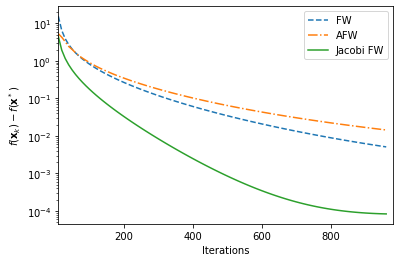

In [ ]:
iterations = 1000
t = 50
M = 0
R = 0
alpha = 1.2
beta = 1.2
g =2/3
prob_type = 0

axis, f1 = FW(X,y,t,M,prob_type,iterations,f_opt,R)
axis, f2 = AFW(X,y,t,M,prob_type,iterations,f_opt,R)
axis, f3 = JFW(X,y,t,alpha,beta,g,M,prob_type,iterations,f_opt,R)
plt.semilogy(axis,f1,'--') 
plt.semilogy(axis,f2,'-.') 
plt.semilogy(axis,f3) 
plt.xlim([10,iterations-20])
plt.legend(['FW','AFW','Jacobi FW'])
plt.xlabel('Iterations')
plt.ylabel(r'$f(\mathbf{x}_k) - f(\mathbf{x}^*)$')

**Robust regression**

Next, we consider robust ridge regression using the Huber loss function with an $\ell_2$-norm constraint as before, i.e.,
\begin{align*} 
   &\underset{\mathbf{x}}{\text{minimize}}\quad \frac{1}{m}\sum_{i=1}^{m}H_{\delta}(y_i - \langle\mathbf{a}_i ,\mathbf{x}\rangle) \\ 
   &\text{s. to} \quad ||\mathbf{x}||_2 \leq t
\end{align*}

where $\mathbf{a}_i \in \mathbb{R}^d$ and $y_i\in \mathbb{R}$. The Huber loss function is given by
$$
  H_{\delta}(c) =
  \begin{cases}
         c^2, & \text{if $|c|\leq \delta$} \\
         2\delta|c| - \delta^2, & \text{otherwise.} 
  \end{cases}
$$

We apply the robust ridge regression on *Pima Indian diabetes* dataset and the optimal function value is computed using *scikit-learn*. We use $m=767$, $d= 8$, $t=35$, $\delta=0.5$, $\alpha = 1450$, $\beta = 1450$, and $\gamma=0.65$.

In [ ]:
## Reading the data

data_pima = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv',',')
X1_pima = np.asmatrix(data_pima)
y_pima = np.array(X1_pima[:,8])
y_pima = y_pima.reshape((-1))
X_pima = np.array(X1_pima[:,:8])
m ,n = X_pima.shape
print(m,n)
M_pima = .5 # Huber parameter

767 8


In [ ]:
# Define the Huber loss and its derivative
def fun_Huber_pima(u, M):
  u = -u
  n = np.size(u)
  X = np.zeros(n)
  for j in range(n):
    if (np.abs(u[j])>M):
      X[j] = 2*M*np.abs(u[j])  - M**2
    else:
      X[j] =  u[j]**2
  return np.sum(X)/(m*n)

# Define the gradient Huber loss
def grad_Huber_pima(u, M, A_pima):
  u = -u
  n = np.size(u)
  X = np.zeros(n)
  for j in range(n):
    if (np.abs(u[j])>M):
      X[j] = 2*M*np.sign(u[j]) 
    else:
      X[j] =  u[j]*2
  return np.dot(A_pima.T,X)/(m*n)

In [ ]:
## Optimal function value from scikit learn

from sklearn.linear_model import HuberRegressor

model = HuberRegressor(max_iter=10000).fit(X_pima,y_pima)
x_opt = model.coef_
f_opt_pima = fun_Huber_pima(x_opt,M_pima)
print(f_opt_pima)

4.739110833775196e-06


Text(0, 0.5, '$f(\\mathbf{x}_k) - f(\\mathbf{x}^*)$')

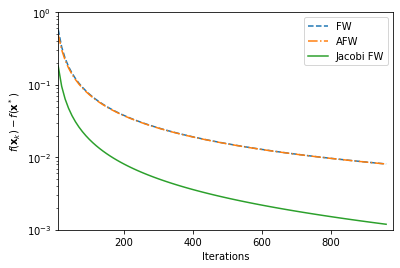

In [ ]:
iterations = 1000
t = 35
M = 0.5
R = 0
alpha = 1450
beta = 1450
g = 0.65
prob_type = 1

axis, f1 = FW(X_pima,y_pima,t,M,prob_type,iterations,f_opt_pima,R)
axis, f2 = AFW(X_pima,y_pima,t,M,prob_type,iterations,f_opt_pima,R)
axis, f3 = JFW(X_pima,y_pima,t,alpha,beta,g,M,prob_type,iterations,f_opt_pima,R)
plt.semilogy(axis,f1,'--') 
plt.semilogy(axis,f2,'-.') 
plt.semilogy(axis,f3) 
plt.ylim([0.001,1])
plt.xlim([10,iterations-20])
plt.legend(['FW','AFW','Jacobi FW'])
plt.xlabel('Iterations')
plt.ylabel(r'$f(\mathbf{x}_k) - f(\mathbf{x}^*)$')

**Robust matrix completion**

Finally, we consider the robust matrix completion problem
to predict the unobserved missing entries from observations with outliers. We use the Huber loss as before along with a low-rank promoting nuclear norm constraint for the robust matrix completion task, i.e., we solve
\begin{align*} 
   & \underset{\mathbf{X}}{\text{minimize}}\,\,  \sum_{(i,j) \in \Omega} H_{\delta}(A_{ij} - X_{ij}) \\ 
   &\text{s. to } \quad \|\mathbf{X}\|_\star\leq R,
\end{align*}
where $\mathbf{A} \in \mathbb{R}^{m \times n}$ is a partially observed matrix with the entries $\mathbf{A}_{ij}$ available for $(i,j) \in \Omega$. The sampling mask $\Omega$ is know. 

We apply robust matrix completion on the {\tt{movielens100K}} dataset where $m = 1682$ movies are rated by $n = 943$ users with $6.30\%$ percent ratings observed. We use 50\% of the available rating for training and the remaining observations for testing. Further, we introduce outliers by setting $4\%$ of the total ratings (i.e., $mn$) to its maximum value. We use $R = 5$, $\alpha=4.5$, $\beta=4.5$, $\gamma = 2/3$ and $\delta = 4$. The normalized error, which is defined as 
$$
\epsilon_k = \frac{\sum_{(i,j) \in \Omega_{\rm test}} H_\delta(A_{ij} - X_{ij})}
{\sum_{(i,j) \in \Omega_{\rm test}} H_\delta(A_{ij})}
$$

In [ ]:
## Reading the data

m = 943
n = 1682
data = pd.read_table('http://files.grouplens.org/datasets/movielens/ml-100k/u.data')
X0 = np.asmatrix(data)
s1 = X0.size
X2 = np.array(X0)
m1 ,n1  = X2.shape

X_mc = np.zeros((m,n),dtype='float')  ## Train set
X1 = np.zeros((m,n),dtype='float') ## Total available set
index = np.zeros((m,n),dtype='int')
index1 = np.zeros((m,n),dtype='int')  ## Train index
for i in range(m1):
  a1 = X2[i,0]
  a2 = X2[i,1]
  index[a1-1,a2-1] = 1
  X1[a1-1,a2-1] = X2[i,2]
  if (np.random.randint(0,2,1)==1):
    X_mc[a1-1,a2-1] = X2[i,2]
    index1[a1-1,a2-1] = 1
index2 = index - index1   ## Test index
s2 = np.count_nonzero(X1)
print(s1,s2)
X3 = X1*index2
count = np.sum(index)
print('count', count)
M = 4  # Huber parameter

## outliers

Rand = np.random.randint(0,25,(m,n))
Rand = np.where(Rand>0,0,1)
print('Percentage of outliers',np.count_nonzero(Rand)/(m*n))
for i in range(m):
  for j in range(n):
    if (Rand[i,j] == 1):
      X_mc[i,j] = 5

399996 99999
count 99999
Percentage of outliers 0.03986064158837318


In [ ]:
# Define the Huber loss
def fun_Huber_mc(u1,X1, M):
  u = (-X1 + u1)*index2
  m,n = np.shape(u)
  X2 = np.zeros((m,n))
  X2 = np.where(np.abs(u) > M,2*M*np.abs(u)  - M**2, u**2 )
  return np.sum(X2)/m*n

# Define the gradient Huber loss
def grad_Huber_mc(u1,X11, M):
  u = (-X11 + u1)*index1
  m,n = np.shape(u)
  X2 = np.zeros((m,n))
  X2 = np.where(np.abs(u)  > M,2*M*np.sign(u), u*2 )
  return X2/(m*n)

## Fuction value of X (H_{\delta}(A))
f_opt_mc = fun_Huber_mc(np.zeros((m,n)),X1,M)
print(f_opt_mc)

1195862.759278897


Text(0, 0.5, '$\\epsilon_k$')

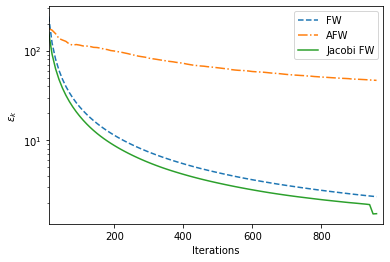

In [ ]:
iterations = 1000
t = 0
M = 4
R = 5
alpha = 4.5
beta = 4.5
g = 2/3
prob_type = 2

axis, f1 = FW(X_mc,X1,t,M,prob_type,iterations,f_opt_mc,R)
axis, f2 = AFW(X_mc,X1,t,M,prob_type,iterations,f_opt_mc,R)
axis, f3 = JFW(X_mc,X1,t,alpha,beta,g,M,prob_type,iterations,f_opt_mc,R)
plt.semilogy(axis,f1,'--') 
plt.semilogy(axis,f2,'-.') 
plt.semilogy(axis,f3) 
plt.xlim([10,iterations-20])
plt.legend(['FW','AFW','Jacobi FW'])
plt.xlabel('Iterations')
plt.ylabel(r'$\epsilon_k$')

In [ ]:
### Valdation of the bound


g1 = np.zeros((3,1000))
a1 = np.zeros((3,1000))
alpha = [1.2,1450,4.5]
beta = [1.2,1450,4.5]
gamm = [2/3,0.65,2/3]
for j in range(3):
  for k in range(2,1000):
    gam = gamm[j]
    a,b,c = constants(k,alpha[j],beta[j])
    a1[j,k] = 1/(k+1) - 1.5*((a*(1-gam) + b)*(beta[j]/alpha[j]))/(k+2)
    g1[j,k] =1/(k+3)

t1 = np.linspace(0,999,1000)

plt.loglog(t1,a1[0,:])
plt.loglog(t1,g1[0,:])
plt.ylabel(r'$\frac{1}{k+1} - \omega_k\left|\frac{\beta}{\alpha}\right|\frac{3}{2(k+2)}$')
plt.xlabel('Iterations')
plt.legend([r'$\alpha=\beta= 1.2,\gamma = \frac{1}{2}$',r'$\frac{1}{k+3}$'])
plt.xlim([2,1000])

plt.figure()
plt.loglog(t1,a1[j,:])
plt.loglog(t1,g1[j,:])
plt.ylabel(r'$\frac{1}{k+1} - \omega_k\left|\frac{\beta}{\alpha}\right|\frac{3}{2(k+2)}$')
plt.xlabel('Iterations')
plt.legend([r'$\alpha=\beta= 1450,\gamma = 0.65$',r'$\frac{1}{k+3}$'])
plt.xlim([2,1000])

plt.figure()
plt.loglog(t1,a1[j,:])
plt.loglog(t1,g1[j,:])
plt.ylabel(r'$\frac{1}{k+1} - \omega_k\left|\frac{\beta}{\alpha}\right|\frac{3}{2(k+2)}$')
plt.xlabel('Iterations')
plt.legend([r'$\alpha=\beta= 4.5,\gamma = \frac{1}{2}$',r'$\frac{1}{k+3}$'])
plt.xlim([2,1000])